In [10]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import re

In [11]:
# Load training set
training_set = pd.read_csv('../datasets/training_set.csv', index_col= 0)

,review_txt,target
0,"""Yes I'm the law. I represent the law in the ...",0
1,For that and for intriguing intro 2 stars.,0


In [21]:
# Load and compile testing sets
test_pos = pd.read_csv('../datasets/test_pos.csv', index_col=0)
test_pos['target']=1
test_neg = pd.read_csv('../datasets/test_neg.csv', index_col=0)
test_neg['target']=0
testing_set = pd.concat([test_neg,test_pos], axis=0, join='inner')
testing_set.reset_index(inplace=True)
testing_set.drop(columns='num',inplace=True)
testing_set.sample(5)

,review_txt,target
22229,This is a great compendium of interviews and e...,1
13924,"Blue ribbon banners, stars and stripes forever...",1
24038,What's the point of this messages if not to di...,1
11653,While it was nice to see a film about older pe...,0
24491,You don't have to be a fan of the cartoon show...,1


In [19]:
testing_set.to_csv('../datasets/testing_set.csv')

In [73]:
## lengths of reviews
train_lens = []
for i in range(len(training_set)):
    length = str(training_set['review_txt'][i]).count(' ')+1
    train_lens.append(length)
    
test_lens = []
for i in range(len(testing_set)):
    length = str(testing_set['review_txt'][i]).count(' ')+1
    test_lens.append(length)

In [89]:
train_test_lens = pd.DataFrame({'train':train_lens[:-123], 'test': test_lens})
train_test_lens.head()

,train,test
0,269,307
1,9,157
2,126,193
3,333,179
4,150,116


In [94]:
train_test_lens.describe()

,train,test
count,24886.000000,24886.000000
mean,233.389456,227.924576
std,173.750475,169.017025
min,1.000000,1.000000
25%,127.000000,125.000000
50%,174.000000,171.000000
75%,284.000000,276.000000
max,2470.000000,2278.000000


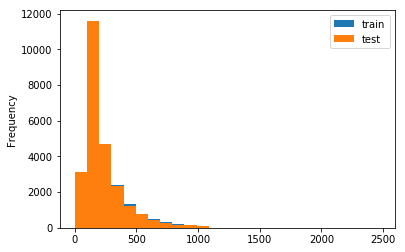

In [133]:
%matplotlib inline
train_test_lens.plot.hist(bins=25)

In [137]:
train_test_lens.quantile(.9975)

train    999.0
test     996.0
Name: 0.9975, dtype: float64

In [98]:
# only .2% of reviews, approximately 100 out of 50,000, are over 1000 words long 
max_length = 1000

## X_train, X_test, y_train, y_test

In [78]:
X_train = training_set.review_txt
y_train = training_set.target
X_test = testing_set.review_txt
y_test = testing_set.target

## Stopwords

In [138]:
# stopwords_list = stopwords.words('english')
# keepwords = ['don', 
#              "don't",
#              'should',
#              "should've",
#              'no',
#              'ain',
#              'aren',
#              "aren't",
#              'couldn',
#              "couldn't",
#              'didn',
#              "didn't",
#              'doesn',
#              "doesn't",
#              'hadn',
#              "hadn't",
#              'hasn',
#              "hasn't",
#              'haven',
#              "haven't",
#              'isn',
#              "isn't",
#              'ma',
#              'mightn',
#              "mightn't",
#              'mustn',
#              "mustn't",
#              'needn',
#              "needn't",
#              'shan',
#              "shan't",
#              'shouldn',
#              "shouldn't",
#              'wasn',
#              "wasn't",
#              'weren',
#              "weren't",
#              'won',
#              "won't",
#              'wouldn',
#              "wouldn't"]
# stopwords_edited = [stopword for stopword in stopwords_list if stopword not in keepwords]

## Tokenize

In [51]:
tk = Tokenizer(num_words = 20000,
              filters = '!"#$@%^&*()_+=<>?[]{}~`\t\n',
              lower= True,
              split = ' ')

In [40]:
tk.fit_on_texts(X_train)

In [80]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [81]:
y_train_seq = y_train.to_numpy
y_test_seq = y_test.to_numpy

In [160]:
tk.get_config()

{'num_words': 20000,
 'filters': '!"#$@%^&*()_+=<>?[]{}~`\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': None,
 'document_count': 0,
 'word_counts': '{}',
 'word_docs': '{}',
 'index_docs': '{}',
 'index_word': '{}',
 'word_index': '{}'}

## Pad sequences

In [76]:
from keras.preprocessing.sequence import pad_sequences

In [99]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=max_length)

In [153]:
glove_df = pd.read_csv('../../Downloads/glove.6B/glove.6B.100d.txt', dtype=str, delimiter=' ', header=None)

In [155]:
glove_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,the,-0.038194,-0.24487,0.72812,-0.39961,0.083172,0.043953,-0.39141,0.3344,-0.57545,...,0.016215,-0.017099,-0.38984,0.87424,-0.72569,-0.51058,-0.52028,-0.1459,0.8278,0.27062
1,",",-0.10767,0.11053,0.59812,-0.54361,0.67396,0.10663,0.038867,0.35481,0.06351,...,0.34951,-0.7226,0.37549,0.4441,-0.99059,0.61214,-0.35111,-0.83155,0.45293,0.082577
2,.,-0.33979,0.20941,0.46348,-0.64792,-0.38377,0.038034,0.17127,0.15978,0.46619,...,-0.063351,-0.67412,-0.068895,0.53604,-0.87773,0.31802,-0.39242,-0.23394,0.47298,-0.028803
3,of,-0.1529,-0.24279,0.89837,0.16996,0.53516,0.48784,-0.58826,-0.17982,-1.3581,...,0.18712,-0.018488,-0.26757,0.727,-0.59363,-0.34839,-0.56094,-0.591,1.0039,0.20664
4,to,-0.1897,0.050024,0.19084,-0.049184,-0.089737,0.21006,-0.54952,0.098377,-0.20135,...,-0.13134,0.058617,-0.31869,-0.61419,-0.62393,-0.41548,-0.038175,-0.39804,0.47647,-0.15983
5,and,-0.071953,0.23127,0.023731,-0.50638,0.33923,0.1959,-0.32943,0.18364,-0.18057,...,0.014487,-0.6259,-0.32367,0.41862,-1.0807,0.46742,-0.49931,-0.71895,0.86894,0.19539
6,in,0.085703,-0.22201,0.16569,0.13373,0.38239,0.35401,0.01287,0.22461,-0.43817,...,0.40215,-0.12746,-0.20228,0.87368,-0.545,0.79205,-0.20695,-0.074273,0.75808,-0.34243
7,a,-0.27086,0.044006,-0.02026,-0.17395,0.6444,0.71213,0.3551,0.47138,-0.29637,...,0.57201,0.088945,-0.42532,-0.018253,-0.079995,-0.28581,-0.01089,-0.4923,0.63687,0.23642
8,"'""'",-0.30457,-0.23645,0.17576,-0.72854,-0.28343,-0.2564,0.26587,0.025309,-0.074775,...,-0.658,-0.16735,0.35158,0.74337,0.26074,0.061104,-0.39079,-0.84557,-0.035432,0.17036
9,'s,0.58854,-0.2025,0.73479,-0.68338,-0.19675,-0.1802,-0.39177,0.34172,-0.60561,...,1.0149,0.77649,0.12598,0.54779,-1.0316,0.064599,-0.37523,-0.94475,0.61802,0.39591
